<a href="https://colab.research.google.com/github/DeStefanoMatteo/progetti-Python/blob/main/Analisi_Dati_E-commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**E-commerce - Analisi Dati**

L'obiettivo di questo notebook è analizzare il contenuto di un database di un E-commerce che vende regali e piccoli prodotti all'ingrosso, che contiene gli acquisti fatti da ~4'000 clienti lungo il periodo di un anno (dal 01-12-2010 al 09-12-2011).

L'analisi effettuata vuole rispondere alle domande più importanti riguardo il comportamento dei clienti...

##**Risultati**

In [ ]:
#@title Codice per la preparazione dei dati...
from google.colab import files

uploaded = files.upload()

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
from IPython.display import display_html

%matplotlib inline
pd.set_option('max_columns', None)

df = pd.read_csv('ecommerce_data.csv', encoding= 'ISO-8859-1')

df.rename(index=str, columns={'InvoiceNo': 'invoice_num',
                              'StockCode' : 'stock_code',
                              'Description' : 'description',
                              'Quantity' : 'quantity',
                              'InvoiceDate' : 'invoice_date',
                              'UnitPrice' : 'unit_price',
                              'CustomerID' : 'customer_id',
                              'Country' : 'country'}, inplace=True)

# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(round(df.isnull().sum()/df.shape[0]*100, 2)).T.rename(index={0:'null values (%)'}))

# df without missing values
df.dropna(inplace = True)

# Drop duplicated rows
df.drop_duplicates(inplace = True)

# change the invoice_date format - String to Timestamp format
df['invoice_date'] = pd.to_datetime(df.invoice_date, format='%m/%d/%Y %H:%M')

# change description - UPPER case to LOWER case
df['description'] = df.description.str.lower()

# change columns type - String to Int type
df['customer_id'] = df['customer_id'].astype('int64')

codes = [el for el in df["stock_code"].unique().tolist() if (len(el) < 5) or (len(el) > 7)]
codes.remove("D")
df = df[~df["stock_code"].isin(codes)]

df_delete = df[df["quantity"] < 0].copy()
df_delete["quantity"] = -df_delete["quantity"]
df_delete = pd.merge(df, df_delete, how='inner', left_on=["stock_code", "customer_id", "quantity"], right_on=["stock_code", "customer_id", "quantity"])
invoice_delete = df_delete[["invoice_num_x", "stock_code", "customer_id", "quantity"]]
invoice_delete.rename(index=str, columns={'invoice_num_x': 'invoice_num'}, inplace=True)

# Create Dataframe containing negative quantities
invoice_delete_C = df_delete[["invoice_num_y", "stock_code", "customer_id", "quantity"]]
invoice_delete_C.rename(index=str, columns={'invoice_num_y': 'invoice_num'}, inplace=True)
invoice_delete_C['quantity'] = -invoice_delete_C['quantity']

# Update Dataframe with invoice to delete and positive quantities
df = df.merge(invoice_delete, on=["invoice_num", "stock_code", "customer_id", "quantity"], how='outer', indicator='merge')
df = df[df['merge']=='left_only']
df.drop('merge', axis=1, inplace=True)

# Update Dataframe with invoice to delete and negative quantities
df = df.merge(invoice_delete_C, on=["invoice_num", "stock_code", "customer_id", "quantity"], how='outer', indicator='merge')
df = df[df['merge']=='left_only']
df.drop('merge', axis=1, inplace=True)

# Delete negative quantities
df = df[(df["stock_code"] != "D") & (df["quantity"] > 0)]
df = df[df['unit_price'] != 0]

df_price = df[(df['unit_price']<20) & (df['stock_code'] != 'D')].groupby(['stock_code', 'unit_price'])['quantity'].sum()
prices = [p[1] for p in df_price.index.values]

df_country = df.groupby('country')['invoice_num'].count().sort_values()

df['amount_spent'] = df['quantity'] * df['unit_price']

df.insert(loc=2, column='date', value=df['invoice_date'].dt.date)
df.insert(loc=3, column='month', value=df['invoice_date'].dt.month)
df.insert(loc=4, column='weekday', value=df['invoice_date'].dt.dayofweek)
df.insert(loc=5, column='hour', value=df['invoice_date'].dt.hour)

country_sorted = sorted(df['country'].unique().tolist())
time_zone_diff = [9, 1, 2, 1, -4, -5, 1, 2, 1, 1, 0, 0, 2, 1, 1, 2, -1, 2, 1, 8, 2, 2, 1, 1, 1, 1, 0, 1, 2, 7, 1, 1, 1, -7, 3, 0, 0]
df_timezone = pd.DataFrame()
df_timezone['country'] = country_sorted
df_timezone['time_diff'] = time_zone_diff

df = df.merge(df_timezone, how='left', on='country')
df['local_hour'] = df['hour'] + df['time_diff']

def local_weekday(row):
  if row['local_hour'] > 23:
    return row['weekday'] + 1
  elif row['local_hour'] < 0:
    return row['weekday'] - 1
  else:
    return row['weekday']

df['local_weekday'] = df.apply (lambda row: local_weekday(row), axis=1)
df['local_hour'] = df['local_hour'] % 24

# rearrange all the columns for easy reference
df = df[['invoice_num','invoice_date','stock_code','description','quantity','unit_price','amount_spent',
         'customer_id','country','time_diff','date','month','weekday','hour','local_weekday','local_hour']]

product_sales = df.groupby(['stock_code'], as_index=False)['invoice_num'].count().sort_values(by='invoice_num', ascending=False)
product_sales = product_sales.merge(df.drop_duplicates('stock_code'), how='left', on="stock_code")[["stock_code", "description", "invoice_num_x"]]
product_sales.rename(columns={'invoice_num_x':'orders'}, inplace=True)

product_sales_plt = product_sales[:20].sort_values(by='orders')

df_purchase = df.groupby(by=['date', 'invoice_num'], as_index=False).count()
df_purchase = df_purchase.groupby(by=['date'], as_index=False)['invoice_num'].count()
df_purchase.rename(columns={'invoice_num':'purchase'}, inplace=True)

max_date = df_purchase[df_purchase['purchase'] == df_purchase['purchase'].max()].iloc[0]['date']
max_value = df_purchase['purchase'].max()
min_date = df_purchase[df_purchase['purchase'] == df_purchase['purchase'].min()].iloc[0]['date']
min_value = df_purchase['purchase'].min()
mean_value = int(df_purchase['purchase'].mean())

df_revenue = df.groupby(by=['date'], as_index=False)['amount_spent'].sum()

df_customer = df.groupby(by=['customer_id', 'invoice_date'], as_index=False)['invoice_num'].count()
df_customer.rename(columns={'invoice_num':'orders'}, inplace=True)
df_customer = df_customer.groupby(by=['customer_id'], as_index=False)['orders'].count()
df_customer_spent = df.groupby(by=['customer_id', 'country'], as_index=False)['amount_spent'].sum()
df_customer = df_customer.merge(df_customer_spent, on=['customer_id'])
df_customer['purchase_avg'] = round(df_customer['amount_spent'] / df_customer['orders'], 2)

df_customer_plt = df_customer.sort_values(by='orders', ascending=False).reset_index(drop=True)
df_customer_plt = df_customer_plt[:20].sort_values(by='orders')

ltv_data = []
for ord_ in range(41):
  ltv = round(df_customer[df_customer['orders'] > ord_]['amount_spent'].mean(), 2)
  ltv_data.append((ord_, ltv))
ltv_data = pd.DataFrame(ltv_data, columns=['order_num', 'ltv'])

df_month = df.groupby(['month', 'invoice_num'], as_index=False)['quantity'].count()
df_month.rename(columns={'quantity':'orders'}, inplace=True)
df_month = df_month.groupby(['month'], as_index=False)['orders'].sum()

df_hour = df.groupby(['local_hour', 'invoice_num'], as_index=False)['quantity'].count()
df_hour.rename(columns={'quantity':'orders'}, inplace=True)
df_hour = df_hour.groupby(['local_hour'], as_index=False)['orders'].sum()

df_hour_plt = df_hour[(df_hour['local_hour'] > 6) & (df_hour['local_hour'] < 22)]

### **Dati E-commerce**

I dati disponibili sono i seguenti:<br><br>
**invoice_num** - ID dell'ordine.<br>
**stock_code** - ID del prodotto.<br>
**description** - descrizione del prodotto.<br>
**quantity** - quantità del prodotto acquistata.<br>
**invoice_date** - data e ora dell'acquisto.<br>
**unit_price** - prezzo del singolo prodotto.<br>
**customer_id** - ID del cliente.<br>
**country** - nazione del cliente.<br>

Per prima cosa abbiamo effettuato una pulizia dei dati. Abbiamo eliminato le osservazioni con valori nulli, le osservazioni duplicate, gli acquisti cancellati e particolari operazioni non utili alla nostra analisi.<br>
Utilizzando i dati disponibili abbiamo creato nuove variabili come l'orario d'acquisto aggiustato per il fuso orario del cliente. Il risultato è stato un dataset dalla seguente dimensione.

In [ ]:
#@title Dimensioni dataset

print(f'Righe: {df.shape[0]}')
print(f'Colonne: {df.shape[1]}')

Righe: 385929
Colonne: 16


### **Analisi**

### **Clienti**

In [ ]:
#@title Numero di clienti

customer_tot = len(df_customer['customer_id'].unique())
print(f"Il dataset contiene gli acquisti di {customer_tot} clienti.")

Il dataset contiene gli acquisti di 4321 clienti.


La loro nazionalità è principalmente Inglese, essendo l'e-commerce studiato situato in Gran Bretagna.<br>

In [ ]:
#@title Nazionalità dei clienti

df_customer.groupby('country', as_index=False)['customer_id'].count().sort_values(by='customer_id', ascending=False).rename(columns={'customer_id':'customers'}).reset_index(drop=True).head(10)

,country,customers
0,United Kingdom,3906
1,Germany,94
2,France,87
3,Spain,29
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,14
8,Finland,12
9,Austria,11


Se non consideriamo i clienti inglesi, possiamo vedere come la clientela sia globale.

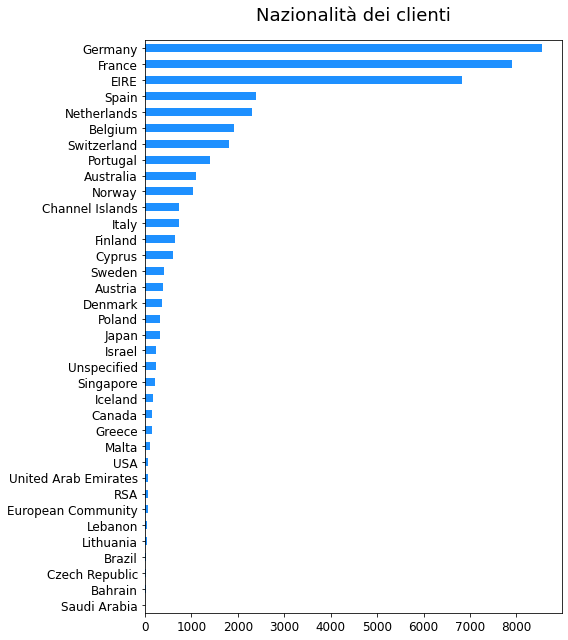

In [ ]:
#@title Grafico nazionalità

# del df_country['United Kingdom']

plt.subplots(figsize=(8,9))
df_country.plot(kind='barh', fontsize=12, color='dodgerblue')
# plt.hist(df['country'], bins=59)
plt.xlabel('')
plt.ylabel('')
plt.title('Nazionalità dei clienti', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Per individuare i clienti di maggior valore per l'e-commerce, creiamo una lista dei clienti che hanno effettuato più ordini e una lista di quelli che hanno speso di più, associati alla loro nazionalità.

In [ ]:
#@title Clienti più attivi

df1 = df_customer_plt[['customer_id', 'orders', 'country']].sort_values(by='orders', ascending=False).reset_index(drop=True).head()
df2 = df_customer_plt[['customer_id', 'amount_spent', 'country']].sort_values(by='amount_spent', ascending=False).reset_index(drop=True).head()
df2['amount_spent'] = df2['amount_spent'].astype('int')

df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Clienti con più ordini')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Clienti con spesa maggiore')

display_html(df1_styler._repr_html_() + "\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0" + df2_styler._repr_html_(), raw=True)

,customer_id,orders,country
0,12748,203,United Kingdom
1,14911,192,EIRE
2,17841,124,United Kingdom
3,14606,91,United Kingdom
4,15311,90,United Kingdom
,customer_id,amount_spent,country
0,14646,277460,Netherlands
1,18102,259657,United Kingdom
2,17450,189607,United Kingdom
3,14911,121172,EIRE


Visualizziamo la quantità di ordini effettuata dai 20 clienti più attivi.

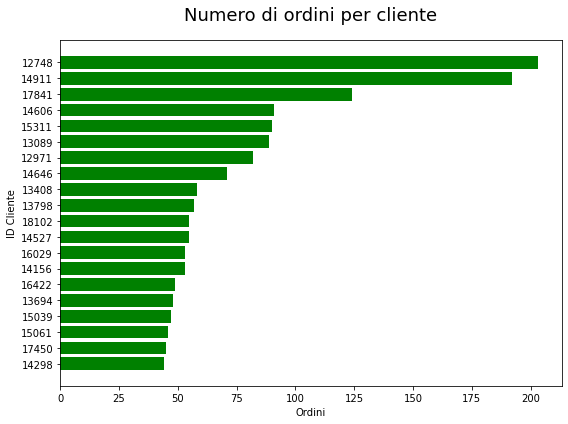

In [ ]:
#@title Ordini per cliente

plt.subplots(figsize=(8,6))
plt.barh(df_customer_plt['customer_id'].astype('str'), df_customer_plt['orders'], color='g')
plt.xlabel('Ordini')
plt.ylabel('ID Cliente')
plt.title('Numero di ordini per cliente', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
#@title Statistiche clienti

orders_tot = df_customer['orders'].sum()
orders_top20 = df_customer_plt['orders'].sum()

print(f"I 20 clienti con più ordini - il {round(20/customer_tot * 100, 2)}% della clientela - ha effettuato {round(orders_top20/orders_tot*100, 2)}% degli acquisti totali.")

I 20 clienti con più ordini - il 0.46% della clientela - ha effettuato 8.57% degli acquisti totali.


Il numero di ordini effettuati e il fatturato per cliente segue la legge di Pareto.

### **Prodotti**

Un e-commerce deve tenere monitorati quali sono i prodotti più acquistati sulla sua piattaforma. Individuiamo i cinque prodotti più acquistati con la loro descrizione.

In [ ]:
#@title Prodotti più acquistati

product_sales[['description', 'orders']].head()

,description,orders
0,white hanging heart t-light holder,1993
1,regency cakestand 3 tier,1622
2,jumbo bag red retrospot,1574
3,assorted colour bird ornament,1389
4,party bunting,1366


Visualizziamo il numero di acquisti dei 20 prodotti più venduti.

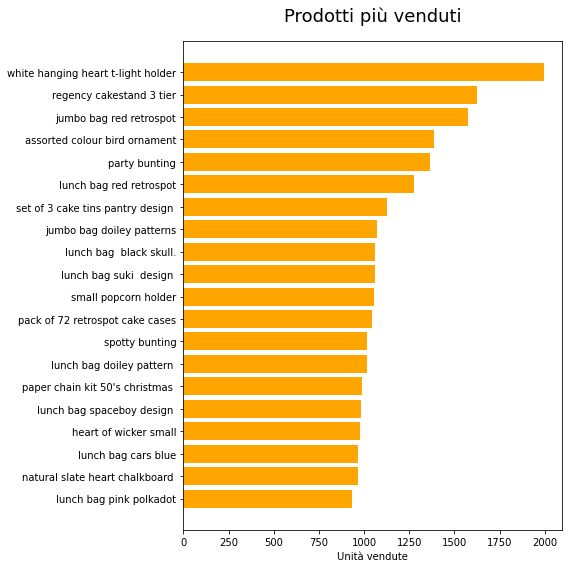

In [ ]:
#@title Prodotti più acquistati

plt.subplots(figsize=(8,8))
plt.barh(product_sales_plt['description'], product_sales_plt['orders'], color="orange")
plt.xlabel('Unità vendute')
plt.title('Prodotti più venduti', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

È importante anche monitorare quali prodotti non vendono.

In [ ]:
#@title Prodotti di scarso successo

product_onesale = product_sales[product_sales['orders'] == 1].shape[0]
print(f"Su un totale di {product_sales.shape[0]} prodotti venduti, {product_onesale} hanno venduto un unico pezzo.\n\n Per esempio:\n")
product_sales[product_sales['orders'] == 1][['description', 'orders']].reset_index(drop=True).head()

Su un totale di 3644 prodotti venduti, 161 hanno venduto un unico pezzo.

 Per esempio:



,description,orders
0,m/colour pom-pom curtain,1
1,purple/blue ceramic candle holder,1
2,diamante necklace,1
3,hen house w chick in nest,1
4,black drop earrings w long beads,1


### **Acquisti**

Visualizziamo il numero di acquisti durante l'anno per individuare eventuali trend.

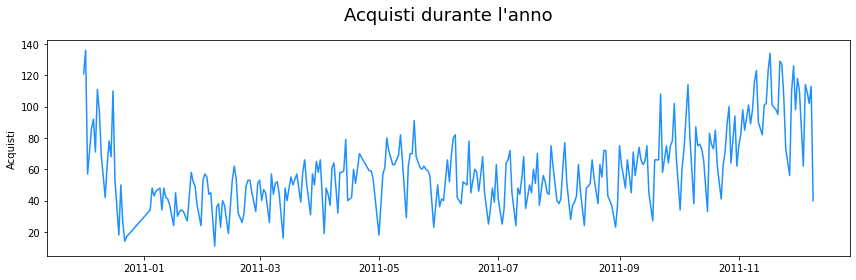

In [ ]:
#@title Acquisti durante l'anno

plt.subplots(figsize=(12,4))
plt.plot(df_purchase['date'], df_purchase['purchase'], color="dodgerblue")
plt.ylabel('Acquisti')
plt.title("Acquisti durante l'anno", fontsize=18, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
#@title Statistiche sugli acquisti

max_date = df_purchase[df_purchase['purchase'] == df_purchase['purchase'].max()].iloc[0]['date']
max_value = df_purchase['purchase'].max()
min_date = df_purchase[df_purchase['purchase'] == df_purchase['purchase'].min()].iloc[0]['date']
min_value = df_purchase['purchase'].min()
mean_value = int(df_purchase['purchase'].mean())

print(f'Giornata migliore: {max_date.strftime("%d/%m/%Y")} con {max_value} acquisti')
print(f'Giornata peggiore: {min_date.strftime("%d/%m/%Y")} con {min_value} acquisti')
print(f'Acquisti giornalieri in media: {mean_value}')

Giornata migliore: 02/12/2010 con 136 acquisti
Giornata peggiore: 06/02/2011 con 11 acquisti
Acquisti giornalieri in media: 59


Il numero di ordini aumenta intorno alle feste natalizie, come ci si può aspettare per un e-commerce che si occupa di prodotti regalo.

### **Fatturato**

Visualizziamo il fatturato nel corso dell'anno.

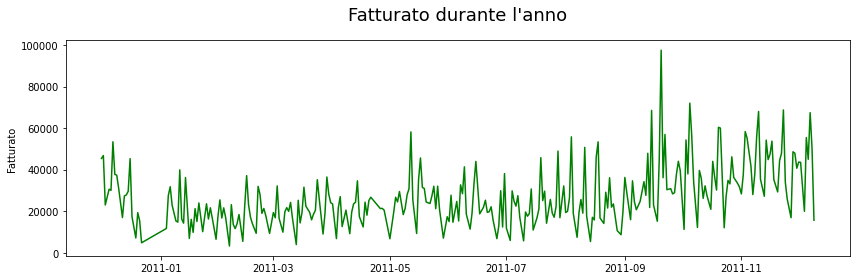

In [ ]:
#@title Fatturato durante l'anno

plt.subplots(figsize=(12,4))
plt.plot(df_revenue['date'], df_revenue['amount_spent'], color="green")
plt.ylabel('Fatturato')
plt.title("Fatturato durante l'anno", fontsize=18, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
#@title Fatturato medio

mean_value = int(df_revenue['amount_spent'].mean())
print(f'Fatturato giornaliero in media: £{mean_value}')

Fatturato giornaliero in media: £26883


Il fatturato cresce verso la fine dell'anno ma è più stabile rispetto a quanto il numero degli ordini possa fare pensare.

### **Carrello**

Il carrello medio è un dato che un e-commerce deve sempre mantenere controllato. La sua distribuzione è la seguente.

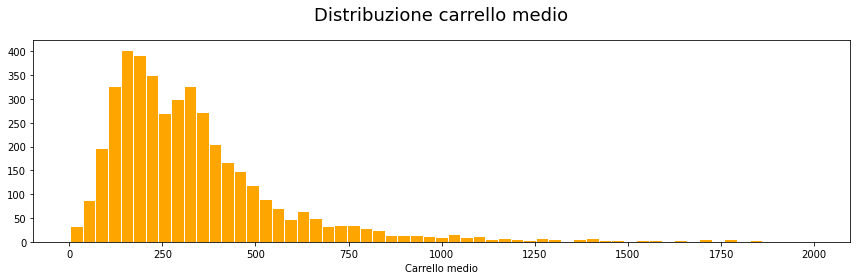

In [ ]:
#@title Distribuzione carrello medio

plt.subplots(figsize=(12,4))
plt.hist(df_customer[df_customer['purchase_avg'] < 2000]['purchase_avg'], 
         bins=59, color='orange', edgecolor='white')
plt.xlabel('Carrello medio')
plt.title('Distribuzione carrello medio', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
#@title Carrello medio

cart_mean = (df_customer['amount_spent'].sum() / df_customer['orders'].sum()).round(2)
print(f'Il carrello medio è di £{cart_mean}')

Il carrello medio è di £452.66


Possiamo vedere come ci siano due mode intorno ai £150 e i £300 di acquisti.

Per quanto riguarda il comportamento dei clienti possiamo visualizzare la distribuzione dei loro orari d'acquisto, corretto per il fuso orario locale.

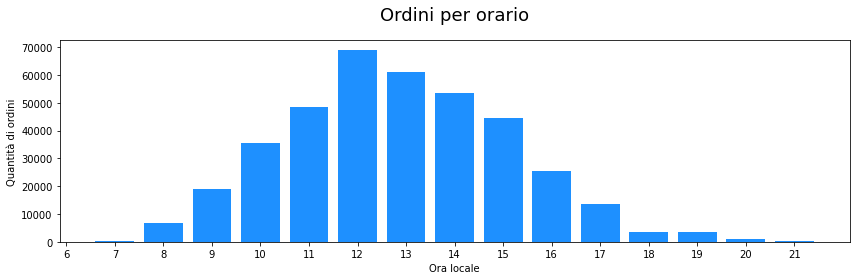

In [ ]:
#@title Ordini per orario

fig, ax = plt.subplots(figsize=(12,4))
plt.bar(df_hour_plt['local_hour'], df_hour_plt['orders'], color='dodgerblue')
plt.xlabel('Ora locale')
ax.set_xticks(range(6,22))
ax.set_xticklabels(range(6,22), rotation='horizontal')
plt.ylabel('Quantità di ordini')
plt.title('Ordini per orario', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

La maggior parte degli acquisti vengono effettuati tra le 11 e le 15.<br>
Questa informazione può essere utile per scegliere l'orario in cui contattare i propri clienti e promuovere nuove offerte.

### **LifeTime Value - LTV**

In [ ]:
#@title LTV medio

ltv_mean = round(df_customer['amount_spent'].mean(), 2)
print(f'Il LTV medio è di £{ltv_mean}')

Il LTV medio è di £1894.51


Visualizziamo come cresce il LTV all'aumentare del numero di ordini dei clienti.

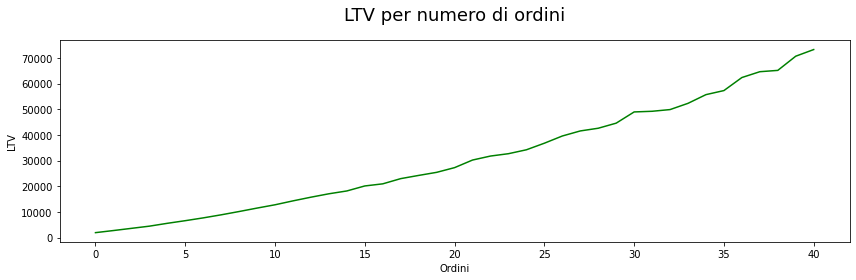

In [ ]:
#@title LTV per numero di ordini

plt.subplots(figsize=(12,4))
plt.plot(ltv_data['order_num'], ltv_data['ltv'], color='green')
plt.xlabel('Ordini')
plt.ylabel('LTV')
plt.title('LTV per numero di ordini', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

La curva indica il crescere del valore dei clienti all'aumentare del loro numero di acquisti.<br>
L'inclinazione della curva è massima tra i 30 e i 40 acquisti. Questo indica, per esempio, come sia più profittevole il prossimo acquisto di qualcuno che ha già effettuato 30 acquisti rispetto a chi ne ha effettuati 10.

Per finire, analizziamo il LTV dei clienti in base alla loro nazionalità per individuare le nazioni su cui potersi focalizzare.<br>
Consideriamo soltanto le nazioni con più di 10 clienti.

In [ ]:
#@title LTV per nazione

df1 = df_customer.groupby('country', as_index=False)['amount_spent'].sum().sort_values(by='amount_spent', ascending=False)
df1['amount_spent'] = round(df1['amount_spent'], 2)

df2 = df_customer.groupby('country', as_index=False)['customer_id'].count().sort_values(by='customer_id')
df2.rename(columns={'customer_id':'clients'}, inplace=True)

df1 = df1.merge(df2, on='country')
df1 = df1[df1['clients'] > 10]
df1['ltv'] = round(df1['amount_spent'] / df1['clients'], 2)
df1 = df1[['country', 'ltv', 'amount_spent', 'clients']]

df1.sort_values(by='ltv', ascending=False).reset_index(drop=True)

,country,ltv,amount_spent,clients
0,Switzerland,2469.49,51859.30,21
1,Germany,2160.53,203089.88,94
2,France,2078.68,180845.39,87
3,Spain,1790.66,51929.22,29
4,United Kingdom,1726.45,6743498.05,3906
5,Finland,1528.74,18344.88,12
6,Belgium,1472.55,36813.69,25
7,Portugal,1396.00,26524.05,19
8,Italy,1104.08,15457.19,14
9,Austria,794.79,8742.68,11


Possiamo notare come i clienti provenienti dalla Svizzera e Germania valgano di più rispetto a quelli provenienti dall'Italia e dall'Austria.<br><br><br><br><br>

## **Analisi Dati con codice - Python**

Importiamo i dati dal file "ecommerce_data.csv" ottenuto al seguente link:<br>
https://www.kaggle.com/carrie1/ecommerce-data

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving ecommerce_data.csv to ecommerce_data.csv


Importiamo i moduli necessari per la nostra analisi.

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
pd.set_option('max_columns', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Caricare i dati**

Carichiamo i dati in formato DataFrame.

In [ ]:
df = pd.read_csv('ecommerce_data.csv', encoding= 'ISO-8859-1')

Dimensione del DataFrame:

In [ ]:
df.shape

(541909, 8)

Rinominiamo le variabili.

In [ ]:
df.rename(index=str, columns={'InvoiceNo': 'invoice_num',
                              'StockCode' : 'stock_code',
                              'Description' : 'description',
                              'Quantity' : 'quantity',
                              'InvoiceDate' : 'invoice_date',
                              'UnitPrice' : 'unit_price',
                              'CustomerID' : 'customer_id',
                              'Country' : 'country'}, inplace=True)

In [ ]:
df.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### **Pulizia dei dati**

Verifichiamo il numero di osservazioni nulle per ciascuna variabile.

In [ ]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(round(df.isnull().sum()/df.shape[0]*100, 2)).T.rename(index={0:'null values (%)'}))
display(tab_info)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
column type,object,object,object,int64,object,float64,float64,object
null values,0,0,1454,0,0,0,135080,0
null values (%),0,0,0.27,0,0,0,24.93,0


Controlliamo le variabili con valori nulli.

In [ ]:
df[df.isnull().any(axis=1)].head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


Il 25% delle transazioni non è legata a nessun cliente. Con i dati disponibili non è possibile assegnare il corretto ID del cliente.<br>
Decidiamo quindi di rimuovere le osservazioni senza un ID cliente.

In [ ]:
df.dropna(inplace = True)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (406829, 8)


Rimuoviamo le osservazioni duplicate.

In [ ]:
print('Duplicated rows: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicated rows: 5225


### **Analisi delle singole variabili**

Sistemiamo il formato delle date, da string a Timestamp.

In [ ]:
df['invoice_date'] = pd.to_datetime(df.invoice_date, format='%m/%d/%Y %H:%M')

Modifichiamo la descrizione dei prodotti in modo che siamo tutte in minuscolo.

In [ ]:
df['description'] = df.description.str.lower()

Trasformiamo l'ID del cliente da variabile float a int.

In [ ]:
df['customer_id'] = df['customer_id'].astype('int64')

Analizziamo la variabile "quantity" tramite istogramma.

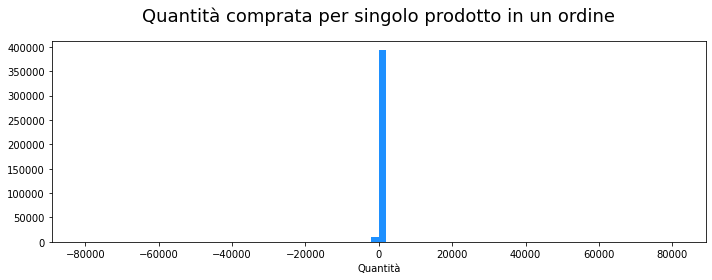

In [ ]:
plt.subplots(figsize=(10,4))
plt.hist(df['quantity'], color='dodgerblue', bins=80)
plt.xlabel('Quantità')
# plt.ylabel('')
plt.title('Quantità comprata per singolo prodotto in un ordine', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Il risulato dell'istogramma è dovuto a valori anomali. Calcoliamo il valore massimo e minimo.

In [ ]:
print(f'Max quantity: {max(df["quantity"])}')
print(f'Min quantity: {min(df["quantity"])}')

Max quantity: 80995
Min quantity: -80995


Verifichiamo quante osservazioni hanno una quantità negativa.

In [ ]:
print(f'Negative quantity: {df[df["quantity"] < 0].shape[0]}')

Negative quantity: 8872


Controlliamo la variabile "stock_code".

In [ ]:
codes = [el for el in df["stock_code"].unique().tolist() if (len(el) < 5) or (len(el) > 7)]
print(codes)
print('Peculiar purchases:', df[df["stock_code"].isin(codes)].shape[0])

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']
Peculiar purchases: 1915


La D indica i "Discount". Eliminiamo tutti i codici particolari tranne gli sconti.

In [ ]:
codes.remove("D")
df = df[~df["stock_code"].isin(codes)]
print(f'Number of rows: {df.shape[0]}')

Number of rows: 399766


In [ ]:
df[df["quantity"] < 0].shape[0]

8583

Eliminiamo tutte le transazioni con quantità negativa a cui corrisponde una quantità positiva.<br>
Si tratta dei casi in cui un acquisto è stato cancellato.

In [ ]:
df_delete = df[df["quantity"] < 0].copy()
df_delete["quantity"] = -df_delete["quantity"]
df_delete = pd.merge(df, df_delete, how='inner', left_on=["stock_code", "customer_id", "quantity"], right_on=["stock_code", "customer_id", "quantity"])

invoice_delete = df_delete[["invoice_num_x", "stock_code", "customer_id", "quantity"]]
invoice_delete.rename(index=str, columns={'invoice_num_x': 'invoice_num'}, inplace=True)

# Create Dataframe containing negative quantities
invoice_delete_C = df_delete[["invoice_num_y", "stock_code", "customer_id", "quantity"]]
invoice_delete_C.rename(index=str, columns={'invoice_num_y': 'invoice_num'}, inplace=True)
invoice_delete_C['quantity'] = -invoice_delete_C['quantity']

# Update Dataframe with invoice to delete and positive quantities
df = df.merge(invoice_delete, on=["invoice_num", "stock_code", "customer_id", "quantity"], how='outer', indicator='merge')
df = df[df['merge']=='left_only']
df.drop('merge', axis=1, inplace=True)

# Update Dataframe with invoice to delete and negative quantities
df = df.merge(invoice_delete_C, on=["invoice_num", "stock_code", "customer_id", "quantity"], how='outer', indicator='merge')
df = df[df['merge']=='left_only']
df.drop('merge', axis=1, inplace=True)

Numero di osservazioni dopo la pulizia:

In [ ]:
df.shape[0]

391386

In [ ]:
df[(df["stock_code"] != "D") & (df["quantity"] < 0)].shape[0]

5350

Sono rimasti circa 5'000 pagamenti con quantità negative a cui non siamo riusciti ad associare un acquisto corrispondente. 77 dei pagamenti sono sconti. Eliminiamo gli acquisti negativi tranne gli sconti.


In [ ]:
df = df[(df["stock_code"] != "D") & (df["quantity"] > 0)]

Analizziamo il prezzo dei prodotti.

In [ ]:
print(f"Gift: {df[df['unit_price'] == 0].shape[0]}")
df = df[df['unit_price'] != 0]

Gift: 30


I prodotti con prezzo uguale a 0 sono possibili regali. Li eliminiamo dal dataset.

Visualizziamo un'istogramma dei prezzi dei prodotti, escludendo i prodotti più costosi.

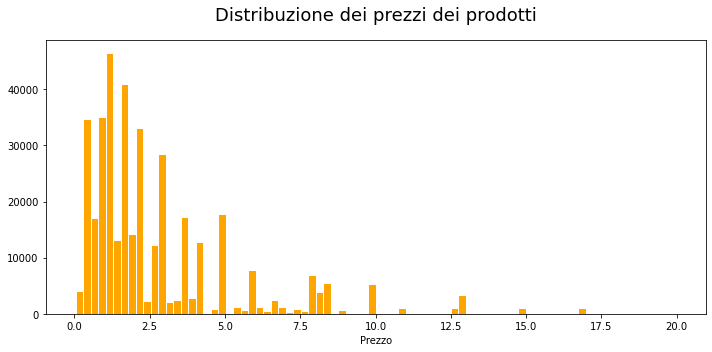

In [ ]:
plt.subplots(figsize=(10,5))
plt.hist(df[df['unit_price']<20]['unit_price'], bins=80, color='orange', edgecolor='white')
# plt.xlim(0, 250)
plt.xlabel('Prezzo')
# plt.ylabel('')
plt.title('Distribuzione dei prezzi dei prodotti', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Visualizziamo la distribuzione delle quantità acquistate per individuare trend particolari.

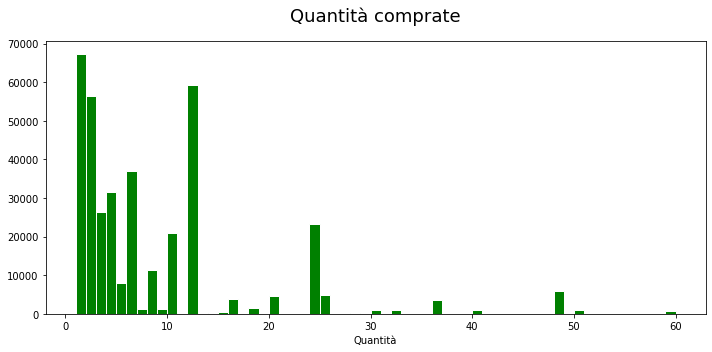

In [ ]:
plt.subplots(figsize=(10,5))
plt.hist(df[(df['quantity'] < 62) & (df['unit_price'] > 0)]['quantity'], bins=59, color='green', edgecolor='white')
plt.xlabel('Quantità')
# plt.ylabel('')
plt.title('Quantità comprate', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Passiamo ad analizzare la nazionalità dei clienti.<br>
Di seguito la frequenza dei clienti per nazione d'origine.

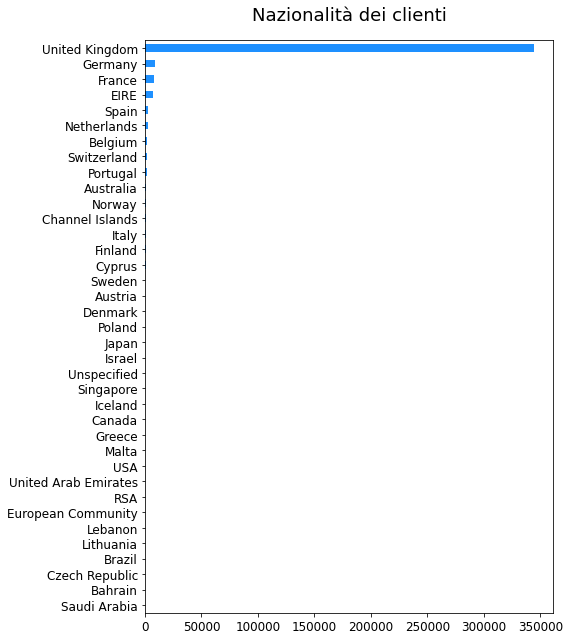

In [ ]:
df_country = df.groupby('country')['invoice_num'].count().sort_values()

plt.subplots(figsize=(8,9))
df_country.plot(kind='barh', fontsize=12, color='dodgerblue')
# plt.hist(df['country'], bins=59)
plt.xlabel('')
plt.ylabel('')
plt.title('Nazionalità dei clienti', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Essendo l'e-commerce britannico, eliminiamo la gran bretagna per poter visualizzare meglio gli altri stati d'origine.

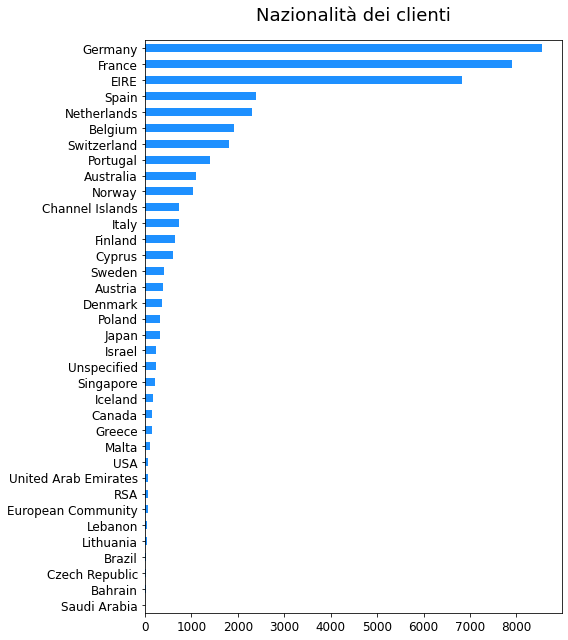

In [ ]:
del df_country['United Kingdom']

plt.subplots(figsize=(8,9))
df_country.plot(kind='barh', fontsize=12, color='dodgerblue')
# plt.hist(df['country'], bins=59)
plt.xlabel('')
plt.ylabel('')
plt.title('Nazionalità dei clienti', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Aggiungiamo la variabile "amount_spent" = "quantity" * "unit_price"

In [ ]:
df['amount_spent'] = df['quantity'] * df['unit_price']

Aggiungiamo le variabili "date", "month", "weekday" e "hour".

In [ ]:
df.insert(loc=2, column='date', value=df['invoice_date'].dt.date)
df.insert(loc=3, column='month', value=df['invoice_date'].dt.month)
df.insert(loc=4, column='weekday', value=df['invoice_date'].dt.dayofweek)
df.insert(loc=5, column='hour', value=df['invoice_date'].dt.hour)

Aggiungiamo le variabili "local_weekday" e "local_hour".

In [ ]:
country_sorted = sorted(df['country'].unique().tolist())
time_zone_diff = [9, 1, 2, 1, -4, -5, 1, 2, 1, 1, 0, 0, 2, 1, 1, 2, -1, 2, 1, 8, 2, 2, 1, 1, 1, 1, 0, 1, 2, 7, 1, 1, 1, -7, 3, 0, 0]
df_timezone = pd.DataFrame()
df_timezone['country'] = country_sorted
df_timezone['time_diff'] = time_zone_diff

df = df.merge(df_timezone, how='left', on='country')
df['local_hour'] = df['hour'] + df['time_diff']

In [ ]:
def local_weekday(row):
  if row['local_hour'] > 23:
    return row['weekday'] + 1
  elif row['local_hour'] < 0:
    return row['weekday'] - 1
  else:
    return row['weekday']

In [ ]:
df['local_weekday'] = df.apply (lambda row: local_weekday(row), axis=1)
df['local_hour'] = df['local_hour'] % 24

Riordiniamo le variabili per comodità.

In [ ]:
# rearrange all the columns for easy reference
df = df[['invoice_num','invoice_date','stock_code','description','quantity','unit_price','amount_spent',
         'customer_id','country','time_diff','date','month','weekday','hour','local_weekday','local_hour']]

In [ ]:
df.head()

,invoice_num,invoice_date,stock_code,description,quantity,unit_price,amount_spent,customer_id,country,time_diff,date,month,weekday,hour,local_weekday,local_hour
0,536365,2010-12-01 08:26:00,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom,0,2010-12-01,12,2,8,2,8
1,536365,2010-12-01 08:26:00,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom,0,2010-12-01,12,2,8,2,8
2,536365,2010-12-01 08:26:00,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom,0,2010-12-01,12,2,8,2,8
3,536365,2010-12-01 08:26:00,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom,0,2010-12-01,12,2,8,2,8
4,536365,2010-12-01 08:26:00,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom,0,2010-12-01,12,2,8,2,8


### **Analisi dei dati**

Individuiamo i 5 prodotti più venduti.

In [ ]:
product_sales = df.groupby(['stock_code'], as_index=False)['invoice_num'].count().sort_values(by='invoice_num', ascending=False)
product_sales = product_sales.merge(df.drop_duplicates('stock_code'), how='left', on="stock_code")[["stock_code", "description", "invoice_num_x"]]
product_sales.rename(columns={'invoice_num_x':'orders'}, inplace=True)
product_sales[['description', 'orders']].head()

,stock_code,description,invoice_num
0,85123A,white hanging heart t-light holder,1993
1,22423,regency cakestand 3 tier,1622
2,85099B,jumbo bag red retrospot,1574
3,84879,assorted colour bird ornament,1389
4,47566,party bunting,1366


Quanti prodotti con un unico acquisto?

In [ ]:
product_sales[product_sales['orders'] == 1].shape[0]

161

Visualizziamo i prodotti per numero di vendite decrescente.

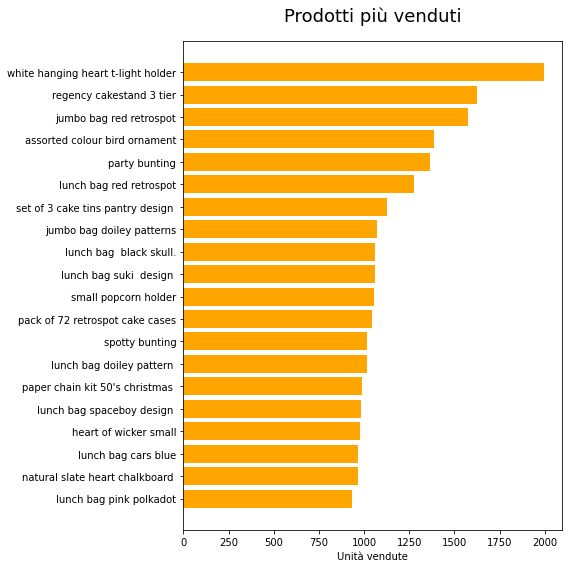

In [ ]:
product_sales_plt = product_sales[:20].sort_values(by='orders')
plt.subplots(figsize=(8,8))
plt.barh(product_sales_plt['description'], product_sales_plt['orders'], color="orange")
plt.xlabel('Unità vendute')
plt.title('Prodotti più venduti', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Numero di clienti totale:

In [ ]:
len(df['customer_id'].unique().tolist())

4321

Calcoliamo il numero di acquisti per ogni giorno dell'anno.

In [ ]:
df_purchase = df.groupby(by=['date', 'invoice_num'], as_index=False).count()
df_purchase = df_purchase.groupby(by=['date'], as_index=False)['invoice_num'].count()
df_purchase.rename(columns={'invoice_num':'purchase'}, inplace=True)
df_purchase.head()

,date,purchase
0,2010-12-01,121
1,2010-12-02,136
2,2010-12-03,57
3,2010-12-05,86
4,2010-12-06,92


Visualizziamo il numero di acquisti durante l'anno.

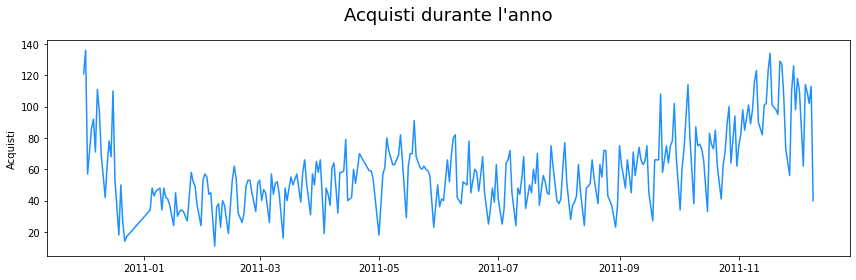

In [ ]:
plt.subplots(figsize=(12,4))
plt.plot(df_purchase['date'], df_purchase['purchase'], color="dodgerblue")
#plt.xlabel('Data')
plt.ylabel('Acquisti')
plt.title("Acquisti durante l'anno", fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Individuiamo la giornata con il numero massimo e minimo di acquisti e gli acquisti medi giornalieri.

In [ ]:
max_date = df_purchase[df_purchase['purchase'] == df_purchase['purchase'].max()].iloc[0]['date']
max_value = df_purchase['purchase'].max()
min_date = df_purchase[df_purchase['purchase'] == df_purchase['purchase'].min()].iloc[0]['date']
min_value = df_purchase['purchase'].min()
mean_value = int(df_purchase['purchase'].mean())

print(f'Giornata migliore: {max_date} con {max_value} acquisti')
print(f'Giornata peggiore: {min_date} con {min_value} acquisti')
print(f'Acquisti giornalieri in media: {mean_value}')

Giornata migliore: 2010-12-02 con 136 acquisti
Giornata peggiore: 2011-02-06 con 11 acquisti
Acquisti giornalieri in media: 59


Visualizziamo il fatturato durante l'anno per valutarne l'andamento.

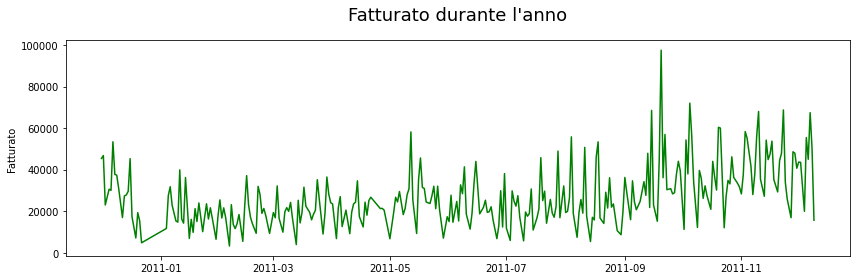

In [ ]:
df_revenue = df.groupby(by=['date'], as_index=False)['amount_spent'].sum()

plt.subplots(figsize=(12,4))
plt.plot(df_revenue['date'], df_revenue['amount_spent'], color="green")
#plt.xlabel('Data')
plt.ylabel('Fatturato')
plt.title("Fatturato durante l'anno", fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Verifichiamo quanti ordini sono stati fatti dai clienti.

Creiamo un DataFrame per i clienti.

In [ ]:
df_customer = df.groupby(by=['customer_id', 'invoice_date'], as_index=False)['invoice_num'].count()
df_customer.rename(columns={'invoice_num':'orders'}, inplace=True)
df_customer = df_customer.groupby(by=['customer_id'], as_index=False)['orders'].count()
df_customer_spent = df.groupby(by=['customer_id', 'country'], as_index=False)['amount_spent'].sum()
df_customer = df_customer.merge(df_customer_spent, on=['customer_id'])
df_customer['purchase_avg'] = round(df_customer['amount_spent'] / df_customer['orders'], 2)
df_customer.head()

,customer_id,orders,country,amount_spent,purchase_avg
0,12347,7,Iceland,4310.00,615.71
1,12348,4,Finland,1437.24,359.31
2,12349,1,Italy,1457.55,1457.55
3,12350,1,Norway,294.40,294.40
4,12352,5,Norway,1125.28,225.06


Individuiamo i clienti con più ordini.

In [ ]:
df_customer_plt = df_customer.sort_values(by='orders', ascending=False).reset_index(drop=True)
df_customer_plt.head()

,customer_id,orders,country,amount_spent,purchase_avg
0,12748,203,United Kingdom,29816.70,146.88
1,14911,192,EIRE,121172.12,631.10
2,17841,124,United Kingdom,37901.76,305.66
3,14606,91,United Kingdom,11196.76,123.04
4,15311,90,United Kingdom,58908.04,654.53


Visualizziamo il numero dei loro acquisti, in ordine decrescente.

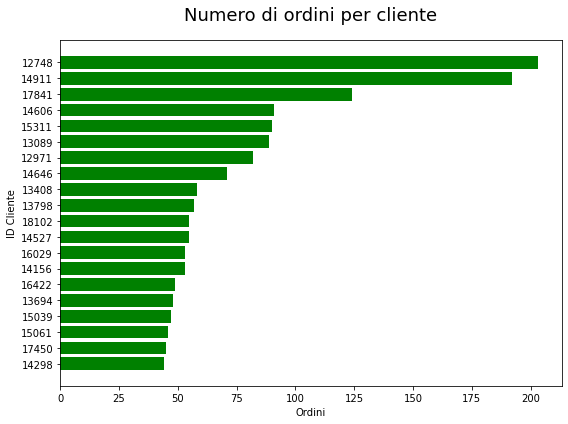

In [ ]:
df_customer_plt = df_customer_plt[:20].sort_values(by='orders')
plt.subplots(figsize=(8,6))
plt.barh(df_customer_plt['customer_id'].astype('str'), df_customer_plt['orders'], color='g')
plt.xlabel('Ordini')
plt.ylabel('ID Cliente')
plt.title('Numero di ordini per cliente', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Calcoliamo il numero medio di acquisti per cliente.

In [ ]:
int(df_customer['orders'].mean())

4

Calcoliamo il valore del carrello medio.

In [ ]:
(df_customer['amount_spent'].sum() / df_customer['orders'].sum()).round(2)

452.66

Visualizziamo la distribuzione del valore dei carrelli dei clienti.

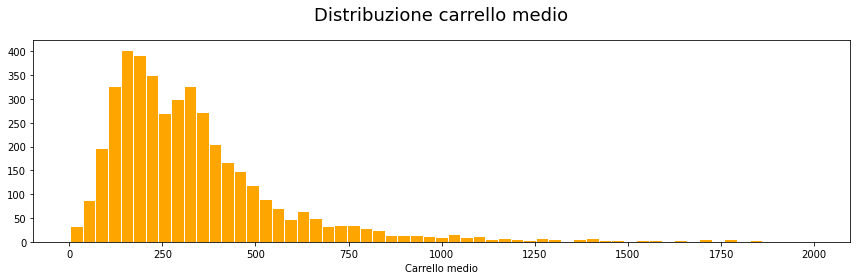

In [ ]:
plt.subplots(figsize=(12,4))
plt.hist(df_customer[df_customer['purchase_avg'] < 2000]['purchase_avg'], 
         bins=59, color='orange', edgecolor='white')
plt.xlabel('Carrello medio')
plt.title('Distribuzione carrello medio', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Individuiamo i clienti con spesa maggiore.

In [ ]:
df_customer.sort_values(by='amount_spent', ascending=False).reset_index(drop=True).head()

,customer_id,orders,country,amount_spent,purchase_avg
0,14646,71,Netherlands,277460.42,3907.89
1,18102,55,United Kingdom,259657.30,4721.04
2,17450,45,United Kingdom,189607.53,4213.50
3,12415,18,Australia,123745.68,6874.76
4,14911,192,EIRE,121172.12,631.10


Calcoliamo il LTV medio tra tutti i clienti.

In [ ]:
round(df_customer['amount_spent'].mean(), 2)

1894.51

Calcoliamo il LTV in base alla nazionalità del cliente. Consideriamo solo le nazioni con più di 10 clienti.

In [ ]:
df1 = df_customer.groupby('country', as_index=False)['amount_spent'].sum().sort_values(by='amount_spent', ascending=False)
df1['amount_spent'] = round(df1['amount_spent'], 2)

df2 = df_customer.groupby('country', as_index=False)['customer_id'].count().sort_values(by='customer_id')
df2.rename(columns={'customer_id':'clients'}, inplace=True)

df1 = df1.merge(df2, on='country')
df1 = df1[df1['clients'] > 10]
df1['ltv'] = round(df1['amount_spent'] / df1['clients'], 2)
df1 = df1[['country', 'ltv', 'amount_spent', 'clients']]

df1.sort_values(by='ltv', ascending=False).reset_index(drop=True)

,country,ltv,amount_spent,clients
0,Switzerland,2469.49,51859.30,21
1,Germany,2160.53,203089.88,94
2,France,2078.68,180845.39,87
3,Spain,1790.66,51929.22,29
4,United Kingdom,1726.45,6743498.05,3906
5,Finland,1528.74,18344.88,12
6,Belgium,1472.55,36813.69,25
7,Portugal,1396.00,26524.05,19
8,Italy,1104.08,15457.19,14
9,Austria,794.79,8742.68,11


Come cresce il LTV all'aumentare degli acquisti?

In [ ]:
ltv_data = []
for ord_ in range(41):
  ltv = round(df_customer[df_customer['orders'] > ord_]['amount_spent'].mean(), 2)
  ltv_data.append((ord_, ltv))
ltv_data = pd.DataFrame(ltv_data, columns=['order_num', 'ltv'])

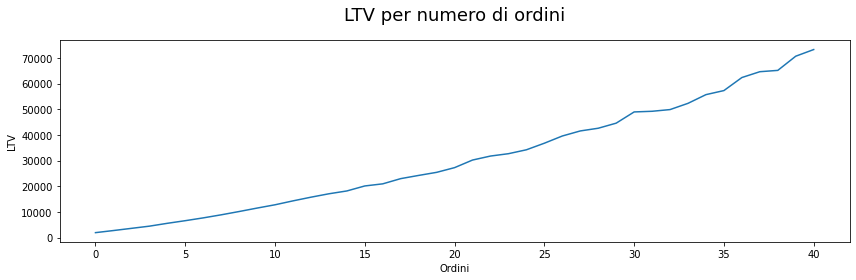

In [ ]:
plt.subplots(figsize=(12,4))
plt.plot(ltv_data['order_num'], ltv_data['ltv'])
plt.xlabel('Ordini')
plt.ylabel('LTV')
plt.title('LTV per numero di ordini', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Visualizziamo quanti ordini vengono effettuati per mese.

In [ ]:
df_month = df.groupby(['month', 'invoice_num'], as_index=False)['quantity'].count()
df_month.rename(columns={'quantity':'orders'}, inplace=True)
df_month = df_month.groupby(['month'], as_index=False)['orders'].sum()

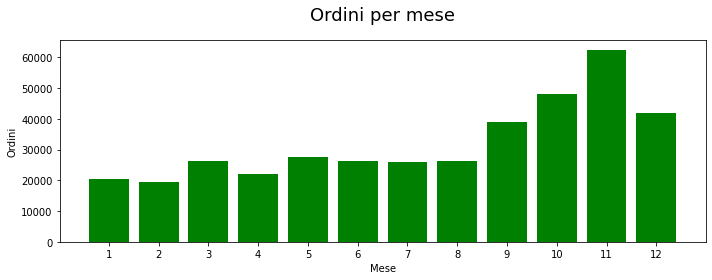

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
plt.bar(df_month['month'], df_month['orders'], color="green")
ax.set_xticks(range(1,13))
ax.set_xticklabels(range(1, 13), rotation='horizontal')
plt.xlabel('Mese')
plt.ylabel('Ordini')
plt.title('Ordini per mese', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Visualizziamo quanti ordini vengono effettuati a seconda dell'orario locale.

In [ ]:
df_hour = df.groupby(['local_hour', 'invoice_num'], as_index=False)['quantity'].count()
df_hour.rename(columns={'quantity':'orders'}, inplace=True)
df_hour = df_hour.groupby(['local_hour'], as_index=False)['orders'].sum()

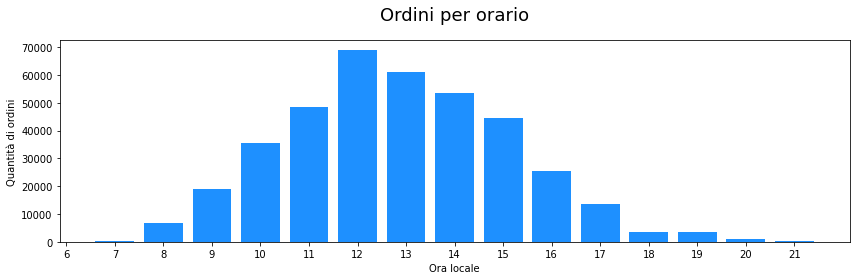

In [ ]:
df_hour_plt = df_hour[(df_hour['local_hour'] > 6) & (df_hour['local_hour'] < 22)]
fig, ax = plt.subplots(figsize=(12,4))
plt.bar(df_hour_plt['local_hour'], df_hour_plt['orders'], color='dodgerblue')
plt.xlabel('Ora locale')
ax.set_xticks(range(6,22))
ax.set_xticklabels(range(6,22), rotation='horizontal')
plt.ylabel('Quantità di ordini')
plt.title('Ordini per orario', fontsize=18, pad=20)
plt.tight_layout()
plt.show()